# Анализ пользовательского поведения в мобильном приложении

## Описание проекта

**Цель проекта**:
- Оценка поведения пользователей мобильного приложения

**Задачи проекта**:
- **Анализ воронки продаж**:
    - Оценка событий, совершаемых пользователями и их количества. 
    - Вяснить сколько пользователей совершали каждое из событий и оценить как пользователи доходят до покупки
    - Оценка количества пользователей которые доходит до покупки, и тех которые  "затревают" на предыдущих шагах
    - Выявить на каких шагах пользователи останавливаются и не совершают покупку   
    
    
- **Анализ результатов A/A/B теста**:

Дизайнеры захотели поменять шрифты во всём приложении. Для оценки правильности такого решения пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами (А1, А2) и одну экспериментальную — с новыми (В).

- Оценка количества пользователей в каждой эксперементальной группе (А1 и А2- контрольные группы )
- A/A-тест - оценка статистических гипотез о равенстве среднего количества пользователей в контрольных группах А1 и А2 во всем логе и в разбивке по событиям
- А/В-тест - оценка статистических гипотез о равенстве среднего количества пользователей в контрольной и тестовой группе
- Оценка уровня значимости для проверки статистических гипотез


**Структура проекта:**
- [Описание данных;](#review)
- [Предобработка данных;](#preprocessing)
- [Изучение и проверка данных;](#analysis)
- [Изучение воронки событий;](#funnel)
- [Анализ результатов A/B теста;](#test)
- [Выводы.](#results)

<a id='review'></a>
###  Описание данных
Каждая запись в логе — это действие пользователя, или событие. 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
import datetime as dt 
import time
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import scipy.stats as stats
import math as mth
from plotly import graph_objects as go
import functools

In [2]:
logs_exp = pd.read_csv('logs_exp.csv',sep='\t')
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<a id='preprocessing'></a>
## Предобработка данных  


Проверим наличие дубликатов и пропусков в данных, а так посмотрим общую информацию о файле. 

In [3]:
display(f'Дубликатов в файле:{logs_exp.duplicated().sum()}({logs_exp.duplicated().sum()/logs_exp.shape[0]:.2%})')
display('Пропусков в данных:',logs_exp.isna().sum())
display(logs_exp.info())

'Дубликатов в файле:413(0.17%)'

'Пропусков в данных:'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

___
* Датафрейм содержит 244 126 строк, из них 413 полностью дублируются, удалим их. 
* Пропусков в данных нет. 
* Дата записана в формате `timestamp`. Создадим столбец с датой в формате `datetime`. Также в столбце с номером эксперимента заменим категориальные переменные строковыми значениями: `246 — А1` и `247 — А2` и `248 — В`.
___

In [4]:
#добавление столбца в формате date_time
logs_exp['date_time'] = logs_exp['EventTimestamp'].map(lambda x: pd.to_datetime(time.strftime("%Y-%m-%d",  time.gmtime(x))))
display(logs_exp['date_time'].dtype)
#переименование столбцов
logs_exp.columns = ['event_name','user_id','event_time_stamp','group','date_time']
# Присвоение категориальным переменным строковых названий
logs_exp['group'] = logs_exp['group'].replace(246,'A1')
logs_exp['group'] = logs_exp['group'].replace(247,'A2')
logs_exp['group'] = logs_exp['group'].replace(248,'B')
display(logs_exp.head())
display(logs_exp.info())
#Удалим дубликаты
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)
display('Дубликатов в файле:',logs_exp.duplicated().sum())

dtype('<M8[ns]')

,event_name,user_id,event_time_stamp,group,date_time
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   user_id           244126 non-null  int64         
 2   event_time_stamp  244126 non-null  int64         
 3   group             244126 non-null  object        
 4   date_time         244126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

'Дубликатов в файле:'

0

<a id='analysis'></a>
## Изучение и проверка данных

**Сколько всего событий в логе?**


In [5]:
display(logs_exp['event_name'].unique(),
        logs_exp['event_name'].nunique(),
       logs_exp['event_name'].count())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

5

243713

___
* В логе всего 5 уникальных событий: 
    * `MainScreenAppear` - Пользователь увидел главный экран
    * `OffersScreenAppear` - Пользователь увидел  экран предложений
    * `CartScreenAppear` - Пользователь зашел в корзину        
    * `PaymentScreenSuccessful` - Пользователь увидел экран успешной оплаты товаров    
    * `Tutorial` -  Пользователь увидел экран с обучением
* Общее число событий: 243 713
___

**Сколько всего пользователей в логе?**


In [6]:
display(logs_exp['user_id'].nunique())

7551

___
* Всего в логе 7 551 пользователь.
___

**Сколько в среднем событий приходится на пользователя?**


In [7]:
round(logs_exp.pivot_table(index='user_id',values = 'event_name',aggfunc = 'count').mean(),2)

event_name    32.28
dtype: float64

___
* В среднем каждый пользователь совершает около 32 событий
___

**Данными за какой период мы располагаем?**

Найдем минимальную и максимальную даты в логе

In [8]:
display(logs_exp['date_time'].min())
display(logs_exp['date_time'].max())
display((logs_exp['date_time'].max()-logs_exp['date_time'].min()).days)

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

13

_____
* Данные в логе содержат информацию о действиях пользователей за 13 дней с 25 июля по 7 августа 2019 года.
___

Посмотрим, как меняется количество данных по дням. Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. 

In [9]:
# Создание сводной таблицы для построения диаграммы
logs_pivot = logs_exp.pivot_table(index=['date_time',
                                         'group'],
                                  values = 'event_name',
                                  aggfunc = 'count').reset_index().sort_values('date_time')
logs_pivot.columns = ['date_time','group','count_event']
groupA1 = logs_pivot.query('group =="A1"')
groupA2 = logs_pivot.query('group =="A2"')
groupB = logs_pivot.query('group =="B"')
logs_pivot.head()

,date_time,group,count_event
0,2019-07-25,A1,4
1,2019-07-25,A2,1
2,2019-07-25,B,4
3,2019-07-26,A1,14
4,2019-07-26,A2,8


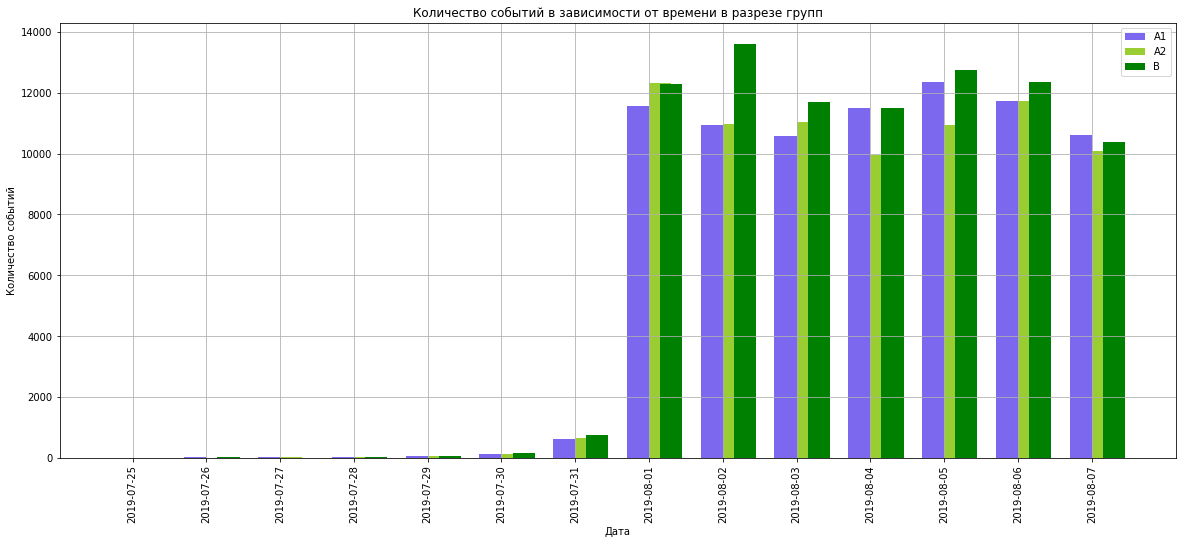

In [10]:
cat_par =[groupA1['date_time'].map(lambda x: x.date()).reset_index(drop=True).loc[i:] for i in range(14)][0].tolist()

A1 = groupA1['count_event']
A2 = groupA2['count_event']
B = groupB['count_event']


width = 0.3

x = np.arange(len(cat_par))

fig, ax = plt.subplots(figsize=(20,8))

ax.bar(x - width/2, A1,width, label='A1',color='mediumslateblue')



ax.bar(x + width/2, A2,width, label='A2',color='yellowgreen')


ax.bar(x + 2*(width/2), B,width, label='B',color='g')
# plt.axhline(y=groupB['count_event'].median(), color='y', linestyle='--',label='medianA1')

plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xticks(x,rotation=90)
ax.set_xticklabels(cat_par)
plt.legend()
plt.xlabel("Дата")
plt.ylabel('Количество событий')
plt.grid()
plt.show()

___
* По диаграмме видно, что до 1 августа данные не полные. 
* Оставим данные за 7 дней с 1 по 7 августа
___

In [11]:
new_logs_exp = logs_exp.query('date_time >= "2019-08-01"')
new_logs_exp.head()

,event_name,user_id,event_time_stamp,group,date_time
2826,Tutorial,3737462046622621720,1564618048,A1,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,A1,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,A1,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,A1,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,A2,2019-08-01


**Много ли событий и пользователей потерялись при удалении данных?**

In [12]:
delit = (logs_exp['user_id'].nunique()-new_logs_exp['user_id'].nunique())/logs_exp['user_id'].nunique()
display(f'Удалено {delit:.2%} пользователей')

delit = (logs_exp['event_name'].nunique()-new_logs_exp['event_name'].nunique())/logs_exp['event_name'].nunique()
display(f'Удалено {delit:.4%} событий')

display(round((logs_exp['event_name'].value_counts()-new_logs_exp['event_name'].value_counts())*100/logs_exp['event_name'].value_counts(),
      2))

'Удалено 0.23% пользователей'

'Удалено 0.0000% событий'

MainScreenAppear           1.49
OffersScreenAppear         1.01
CartScreenAppear           0.86
PaymentScreenSuccessful    0.59
Tutorial                   1.28
Name: event_name, dtype: float64

___
* Было удалено менее четверти процента пользователей
* Ни одно событие полностью не "пропало" из датасета
* По каждому событию в среднем было удалено около 1% записей. Больше всего для события MainScreenAppear, что логично — это самое частое событие в данных.
___

**Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.**

In [13]:
new_logs_exp.pivot_table(index='group', values = 'user_id', aggfunc = 'count')

,user_id
group,
A1,79302
A2,77022
B,84563


___
* Все нормально, во всех трех группах есть пользователи 
___

<a id='funnel'></a>
## Изучение воронки событий

**Посмотрим, как часто встречается каждое событие.** 

In [14]:
new_logs_exp['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

___ 
* Самое популярное событие - просмотр главного экрана встречается в логе 117 328 раз.

* Реже всего пользователи просматривают экран с обучением.
___

**Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.** 

In [15]:
users_committed_event = new_logs_exp.pivot_table(index = 'event_name', 
                                                 values = 'user_id',
                                                 aggfunc = 'nunique')
all_users = new_logs_exp['user_id'].nunique()
users_committed_event.columns = ['nunique_users']
users_committed_event['share_users (%)'] = round(users_committed_event['nunique_users']*100/all_users,2)
users_committed_event.sort_values(by='nunique_users',ascending = False)

,nunique_users,share_users (%)
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


___
* Более 98 процентов пользователей хоть раз просматривали главный экран
* Самая малая доля приходится на просмотр обучения, это событие большая часть пользователей пропускает
___

**Посмотрим самые популярные цепочки событий встречающихся в логе**

In [ ]:
df =[]
users = new_logs_exp['user_id'].unique().tolist()

for u in users:
    j = ' → '.join(new_logs_exp.query('user_id == @u')\
                                      .sort_values(by='date_time')['event_name'].drop_duplicates().reset_index(drop=True))
    df.append(j)

In [ ]:
pd.Series(df).value_counts().head(10)

___
* Как и ожидалось, чаще всего пользователи просматривают главный экран, не переходя в корзину и не совершая покупок
* На втором месте по частоте цепочка: **`MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful`**.  **Для построения воронки событий будем использовать эту цепочку**
* Видно, что есть цепочки, где последовательность нарушается, пользователь перешел на экран оплаты сразу с главного экрана или с экрана предложений минуя корзину. Такое возможно если у пользователя есть прямая ссылка на страницу оплаты или интернет-магазин предлагают возможность совершить покупку в один шаг, без необходимости добавлять товары в корзину. Так же возможны технические ошибки в коде отслеживания корзины. В данных случаях цепочки выглядят так:
`MainScreenAppear → OffersScreenAppear → PaymentScreenSuccessful → CartScreenAppear`             
`MainScreenAppear → PaymentScreenSuccessful → CartScreenAppear → OffersScreenAppear` 
* Доля цепочек не содержит переход к экрану с предложениями, пользователь сразу попадает в корзину
`MainScreenAppear → CartScreenAppear → PaymentScreenSuccessful → OffersScreenAppear`
* Так как очень мало пользователей просматривают обучение,  это событие не нужно учитывать при расчёте воронки.  
___


**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).** 

* Событие 1 - MainScreenAppear
* Событие 2 - OffersScreenAppear
* Событие 3 - CartScreenAppear
* Событие 4 - PaymentScreenSuccessful*

In [ ]:
# Построим таблицу по пользователям с датой первого совершения события
purchase_funnel = new_logs_exp.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='date_time',
    aggfunc='min')
purchase_funnel = purchase_funnel[['MainScreenAppear','OffersScreenAppear' ,'CartScreenAppear' ,'PaymentScreenSuccessful']]
purchase_funnel.head()

In [ ]:
#Построим таблицы для переходов в каждое событие и посчитаем долю пользователей перешедших из события в событие
event1 = purchase_funnel.query('~MainScreenAppear.isna()')
event12 = event1.query('~OffersScreenAppear.isna()')
event123 = event12.query('~CartScreenAppear.isna()')
event1234 = event123.query('~PaymentScreenSuccessful.isna()')

display(f'Доля пользователей перешедших из события 1 в 2: {event12.shape[0]/event1.shape[0]:.2%}')
display(f'Доля пользователей перешедших из события 2 в 3: {event123.shape[0]/event12.shape[0]:.2%}')
display(f'Доля пользователей перешедших из события 3 в 4: {event1234.shape[0]/event123.shape[0]:.2%}')

___
* Самая малая доля пользователей наблюдается при переходе из события 1 в событие 2, т. е.  больше всего пользователей теряется на шаге 1 (`MainScreenAppear`).
___

**Какая доля пользователей доходит от первого события до оплаты?**

In [ ]:
display(f'Доля пользователей перешедших из события 1 в 4: {event1234.shape[0]/event1.shape[0]:.2%}')

___
* От просмотра главного экрана до оплаты доходит 46,22% пользователей 
___

**Визуализируем воронку событий**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Montreal',
    y=["Все пользователи", "MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x=[all_users,event1.shape[0], event12.shape[0], event123.shape[0], event1234.shape[0]],  
    textinfo="value+percent initial",
))
fig.update_layout(
    title_text='Воронка событий'  # Установка названия диаграммы через метод update_layout
)
fig.show()

___
* По визуализации воронки можно подтвердить выводы сделанные выше: Больше всего пользователей теряется при переходе с первого на второй шаг - количество пользователей на 2 шаге на 30 ед. процента меньше, чем на первом, а от первого шага до оплаты доходят только 46% пользователей
___

___
**Общие выводы**
* Самое популярное событие - просмотр главного экрана

* Реже всего пользователи просматривают экран с обучением, это событие большая часть пользователей пропускает

* События происходят в следующем порядке: `Главный экран → Экран с предложениями → Корзина → Экран оплаты`. Не всегда события выстраиваются в последовательную цепочку, такие последовательности мы не учитывали при расчете воронки.

* Больше всего пользователей теряется на первом шаге - при переходе с главного экрана в экран с предложениями. 

* Более половины пользователей с глафного экрана не доходят до совершения покупки.
___


<a id='test'></a>
## Анализ результатов A/B теста

**Посчитаем количество пользователей в каждой экспериментальной группе**

In [ ]:
new_logs_exp.pivot_table(index = 'group', values = 'user_id', aggfunc = 'nunique')

___
* На первый взгляд можно сказать, что группы поделены равномерно.
___

**Проверим, что каждый пользователь принадлежит только одной группе**

In [ ]:
user_list_A1 = new_logs_exp.query('group == "A1"')['user_id'].tolist()
user_list_A2 = new_logs_exp.query('group == "A2"')['user_id'].tolist()
user_list_B = new_logs_exp.query('group == "B"')['user_id'].tolist()

if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,user_list_A1,user_list_A2), True):
    print ("В группах A1 и А2 есть повторяющиеся пользователи")
else:
    print ("В группах A1 и А2 нет одних и тех же пользователей")

if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,user_list_A1,user_list_B), True):
    print ("В группах A1 и B есть повторяющиеся пользователи")
else:
    print ("В группах A1 и B нет одних и тех же пользователей")
    
if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,user_list_A2,user_list_B), True):
    print ("В группах A2 и B есть повторяющиеся пользователи")
else:
    print ("В группах A2 и B нет одних и тех же пользователей")

___
* В группах одних и тех же пользователей не обнаружено
___

**Проверим корректность механизмов деления трафика**

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками А1 и А2.

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп, долю пользователей, совершивших это событие и проверим будет ли отличие между группами статистически достоверным.

In [ ]:
# Функция для подсчета общего количества пользователей по группам, пользователей совершивших события и p_value между выборками
def stats_AB(alpha,group,event):
    for g in group:
        display(f'group: {g}')
        p_value = []
        all_users1 = []
        all_users2 = []
        event_users1 = []
        event_users2= []
        for e in event:
            # все пользователи групп 
            group1 = new_logs_exp.query('group == @g[0]')['user_id'].nunique()
            all_users1.append(group1)
            group2 =  new_logs_exp.query('group == @g[1]')['user_id'].nunique()
            trials = np.array([group1, group2])
            all_users2.append(group2)
            #количество пользователей совершивших событие
            event_group1 = new_logs_exp.query('(group == @g[0]) and (event_name == @e)')['user_id'].nunique()
            event_users1.append(event_group1)
            event_group2 = new_logs_exp.query('(group == @g[1]) and (event_name == @e)')['user_id'].nunique()
            event_users2.append(event_group2)
            successes = np.array([event_group1, event_group2 ])
            # пропорция успехов в первой группе:
            p1 = successes[0]/trials[0]
            # пропорция успехов во второй группе:
            p2 = successes[1]/trials[1]
            # разница пропорций 
            diff = p1-p2
            # комбинация пропорций
            p = (successes[0]+successes[1])/(trials[0]+trials[1])
            # считаем статистику в ст.отклонениях стандартного нормального распределения
            z_value = diff / mth.sqrt(p*(1-p)*(1/trials[0] + 1/trials[1]))
            # нормальное распределение
            distr = st.norm(0,1)
            p_value.append(round((1-distr.cdf(abs(z_value)))*2,2))       
    data = {'event':event,
                f'all_users{group[0][0]}':all_users1 ,f'event_users{group[0][0]}':event_users1,
                f'all_users{group[0][1]}':all_users2 ,f'event_users{group[0][1]}':event_users2}
    frame = pd.DataFrame(data=data)
    frame[f'share{group[0][0]} (%)']  = round(frame[f'event_users{group[0][0]}']*100/frame[f'all_users{group[0][0]}'],2)
    frame[f'share{group[0][1]} (%)']  = round(frame[f'event_users{group[0][1]}']*100/frame[f'all_users{group[0][1]}'],2)
    display(frame)
    
    
    for a in alpha:
        display(f'alpha = {a}')
        conc = []
        for pv in p_value:
            if  pv < a:
                conc.append('есть значимая разница')
            else:
                conc.append('нет значимой разницы')
        data2 = {'p_value': p_value, f'conclusion_alpha_{a}':conc}
        display(pd.DataFrame(index=event,data=data2))

    return 

In [ ]:
stats_AB([0.05],
     [['A1','A2']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

___

* Можно  сказать, что разбиение на группы работает корректно. Статистической разницы между пользователями групп A1 и A2 для каждого из событий не выявлено
___

**Сравним результаты тестовой группы с каждой из контрольных групп в отдельности по каждому событию.**

Также сравним результаты с объединённой контрольной группой.

In [ ]:
stats_AB([0.05],
     [['A1','B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

In [ ]:
stats_AB([0.05],
     [['A2','B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

In [ ]:
stats_AB([0.05],
     [[['A1','A2'],'B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

___
* Статисчитеской разницы между контрольными группами и тестовой группой не выявленно
___

**Скорректируем уровень значимости для множественного сравнения**

При множественной проверке гипотез возрастает групповая вероятность совершить ошибку первого рода. В нашем исследовании мы проводим 16 проверок статистической значимости (A1/A2, A1/B, A2/B, A1A2/B для четырех событий). Для уменьшения FWER скорректируем уровень значимости с помощью поправки Бонферрони.

**Метод Бонферрони**

In [ ]:
alpha = 0.05
bonferroni_alpha = alpha / 16
bonferroni_alpha

In [ ]:
stats_AB([round(bonferroni_alpha,3)],
     [['A1','A2']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

In [ ]:
stats_AB([round(bonferroni_alpha,3)],
     [['A1','B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

In [ ]:
stats_AB([round(bonferroni_alpha,3)],
     [['A2','B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

In [ ]:
stats_AB([round(bonferroni_alpha,3)],
     [[['A1','A2'],'B']],
     ["MainScreenAppear",'OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'])

___
* С коэффициентом уровня значимости в 0.003125 значимой разницы между группами также не выявленно
___

<a id='results'></a>
## Выводы

* Был проведен анализ воронки событий и результатов A/A/B теста по данным из лога с информацией о событиях 7 551 пользователя.
* Было отброшено 0,23% пользователей за даты до 01.08.2019 в виду неполноты данных в эти даты - для анализа были использованы данные за период 01.08.2019 - 07.08.2019
* Самое популярное событие - просмотр главного экрана. Тек же было установлено, что на этом этапе теряется больше всего пользователей и только 46,22% пользователей от просмотра главного экрана переходят к оплате.  
* По результатам A/B теста статистической значимости между контрольными и тестовой группой не выявлено. Смена шрифтов в приложении никак не повлияла на пользователей, они продолжили покупать так же, как и со старыми шрифтами. Решение по результатами теста: остановить тест, зафиксировать отсутствие различий между группами.